In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MDAnalysis as mda
from tqdm import tqdm
import glob
from findiff import FinDiff, coefficients, Coefficient


plt.rcParams.update({
"font.size": 14,
"text.usetex": False,
"mathtext.fontset": "stixsans"
})

root="/scratch/project_465000467/FABIO/Anesthetics"

In [2]:
def get_values(pressures,folder,frames_from_last):

    if frames_from_last:
        print(f"Using last {frames_from_last} frames")
        frames_from_last = -frames_from_last
    else:
        print(f"Using all frames")
        frames_from_last=0

    fill = []
    for press in tqdm(pressures):    
        if press < 0:
            pressname="neg"+str(press)[1:]
        elif press == 0.0:
            pressname=0
        else:
            pressname=press

        try:
            filename = glob.glob(f"{folder}/{pressname}MPa/{pressname}MPa.**.part**.gro")[0]
            trajname = glob.glob(f"{folder}/{pressname}MPa/{pressname}MPa.**.part**.xtc")[0]    
        except:
            continue
        
        u = mda.Universe(filename,trajname)

        cyl = u.select_atoms("resname BULK")
        pis, pis1 = u.select_atoms("resname PIS"), u.select_atoms("resname PIS1")
        water_system = u.select_atoms("resname W or resname SW or resname TW")
        zmin, zmax = np.min(cyl.positions[:,2]), np.max(cyl.positions[:,2])
        water_inside = water_system.select_atoms(f"prop z >= {zmin} and prop z <= {zmax}", updating=True)

        water_list = []
        tjs= u.trajectory[frames_from_last:]
        for ts in tjs:        
            n_water = water_inside.n_atoms
            water_list.append(n_water)
            
        mean = np.mean(water_list)
        std = np.std(water_list)
        fill.append((press,mean,std))
    return np.array(fill)

def stilyze_plot(axis,xlab,ylab):
    axis.tick_params(which='minor', length=3, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)
    axis.tick_params(which='major', length=6, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)
    axis.spines["right"].set_visible(False)
    axis.spines["top"].set_visible(False)
    axis.set_ylabel(ylab,size=14)
    axis.set_xlabel(xlab,size=14)
            
    return

Getting intrusion values...
Using last 10 frames


100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


Getting extrusion values...
Using last 10 frames


100%|██████████| 35/35 [01:49<00:00,  3.13s/it]



Finished. (:



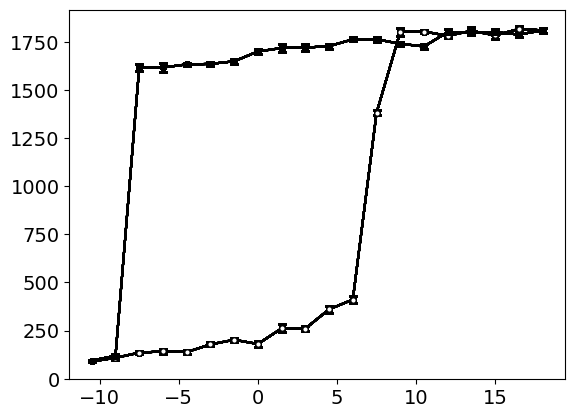

In [38]:
#get cycle

root="/scratch/project_465000467/FABIO/Anesthetics"

system = "C8,1.2"
c = system.split(",")[0]
g = system.split(",")[1]
mol = "Diethyl_ether"
ngas = 1000
run = "eq3"
cycle = "Cycle2"

press_int = np.arange(-10.5,41.0,1.5)
press_ext = np.arange(-10.5,41.0,1.5)
frames_from_last = 10

dir_int = f"{root}/{mol}/{system}/{ngas}/{run}/{cycle}/intrusion"
dir_ext = f"{root}/{mol}/{system}/{ngas}/{run}/{cycle}/extrusion"

print("Getting intrusion values...")
fill_int = get_values(press_int,dir_int,frames_from_last)

print("Getting extrusion values...")
fill_ext = get_values(press_ext,dir_ext,frames_from_last)

df_int = pd.DataFrame(fill_int, columns=["press","mean","std"])
df_int["sys"] = [system]*len(df_int)
df_int["run"] = [run]*len(df_int)

df_ext = pd.DataFrame(fill_ext, columns=["press","mean","std"])
df_ext["sys"] = [system]*len(df_ext)
df_ext["run"] = [run]*len(df_ext)

df_int.to_csv(f"{root}/Int_ext_cycles/intrusion_{mol}_{c}_{g}_{ngas}_{run}_{cycle}.dat",index=False)
df_ext.to_csv(f"{root}/Int_ext_cycles/extrusion_{mol}_{c}_{g}_{ngas}_{run}_{cycle}.dat",index=False)

fig, ax = plt.subplots()
                                     
for press in press_int:
    try:
        ax.errorbar(fill_int[:,0],fill_int[:,1],fill_int[:,2],marker="o",c="black",mfc="white",mec="black",markersize=4,capsize=3)
    except:
        continue

for press in press_ext:
    try:
        ax.errorbar(fill_ext[:,0],fill_ext[:,1],fill_ext[:,2],marker="o",c="black",mfc="black",mec="black",markersize=4,capsize=3)
    except:
        continue

#plt.savefig(f"{root}/plots/{mol}_{system}_{ngas}_{run}_{cycle}.png",dpi=150)
print("\nFinished. (:\n")

In [ ]:
#plot config

import MDAnalysis as mda
root = "/scratch/project_465000467/FABIO/Anesthetics"
Cs = "C18"
grafDens = 1.2
sys = "C8,1.2"
run = "eq3"
mol = "Diethyl_ether"
ngas = 100
cycle = "Cycle2"
path = f"{root}/{mol}/{sys}/{ngas}/{run}/start_gased"

u = mda.Universe(f"{path}/minimized.gro")
bulk = u.select_atoms("resname BULK or resname SI or resname LAY or resname PIS or resname PIS1")
sil = u.select_atoms("resname SIL")
water = u.select_atoms("resname W or resname SW or resname TW")
gas = u.select_atoms("resname ETY or resname CLF or resname ETH")

plt.scatter(bulk.positions[:,2],bulk.positions[:,1], s=0.1, alpha=0.1)
plt.scatter(water.positions[:,2],water.positions[:,1], s=0.1, alpha=0.1)
plt.scatter(sil.positions[:,2],sil.positions[:,1], s=1)
plt.scatter(gas.positions[:,2],gas.positions[:,1], s=5)

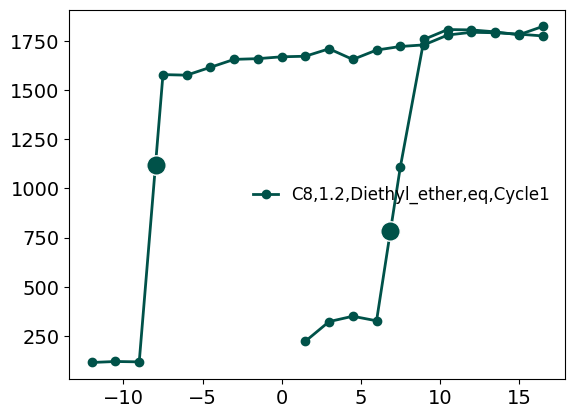

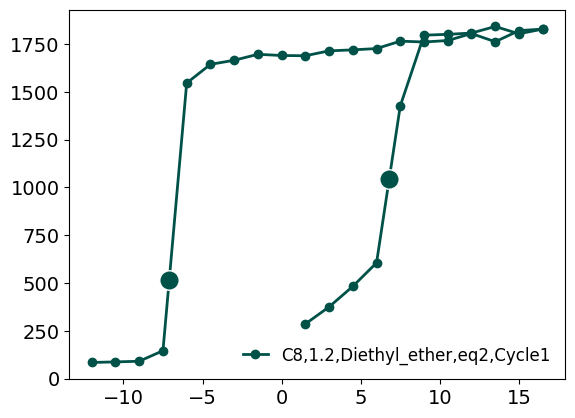

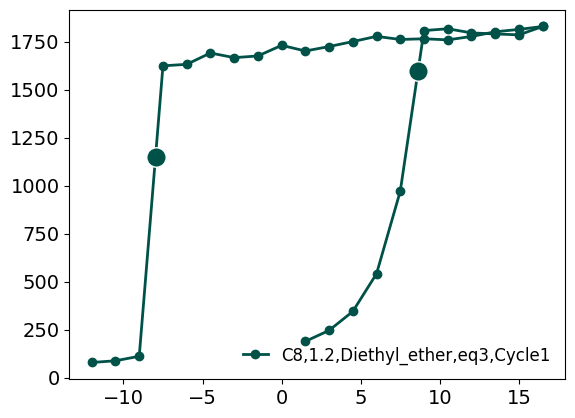

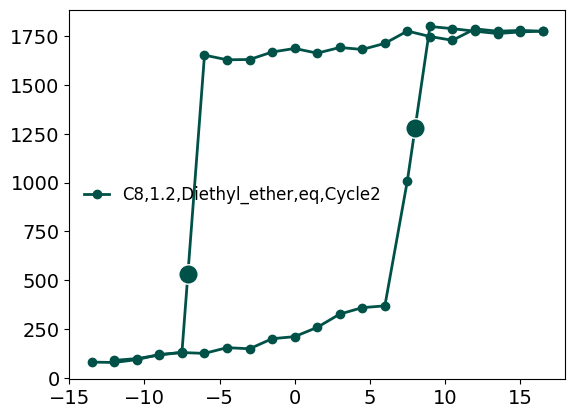

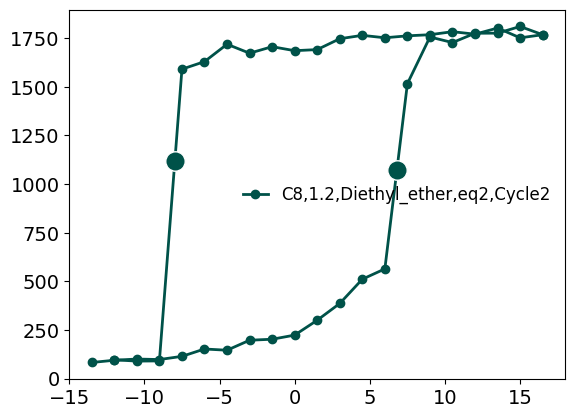

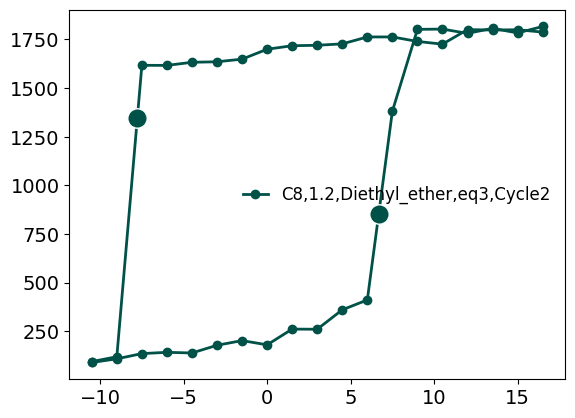

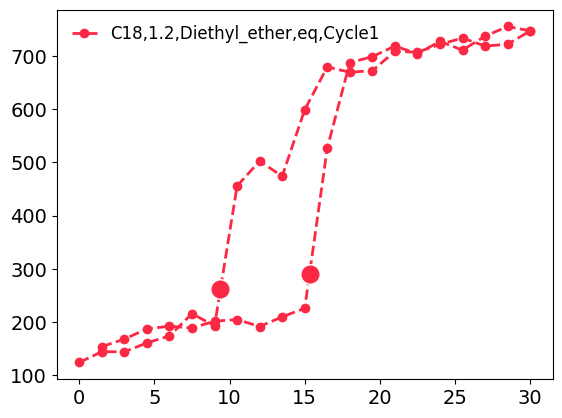

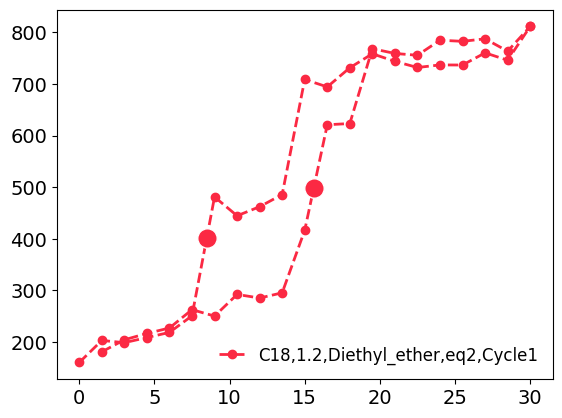

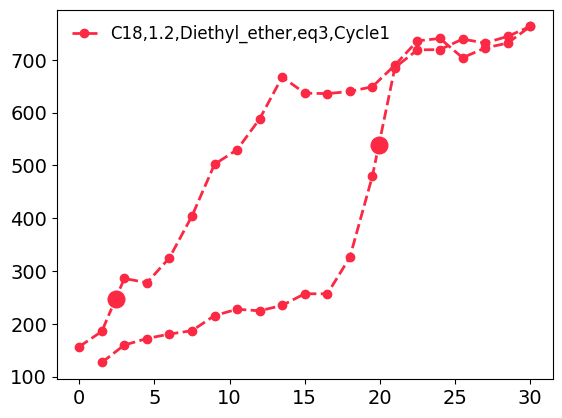

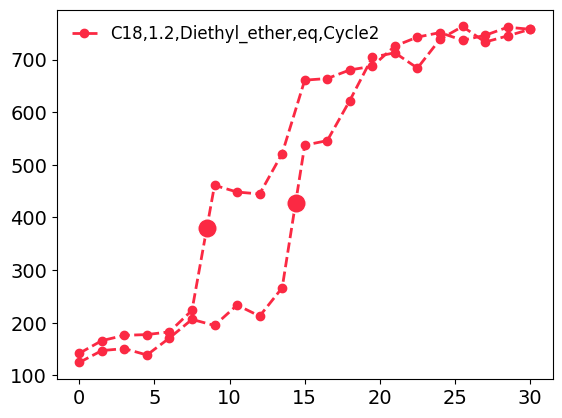

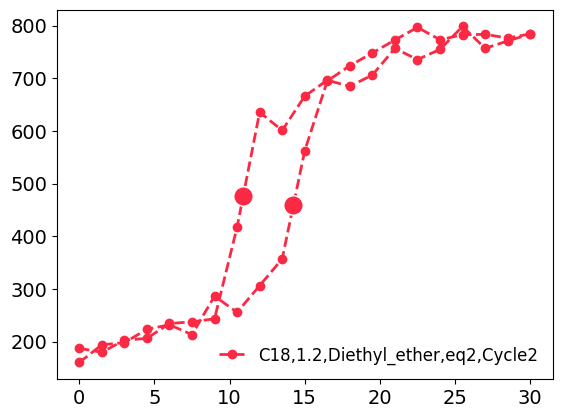

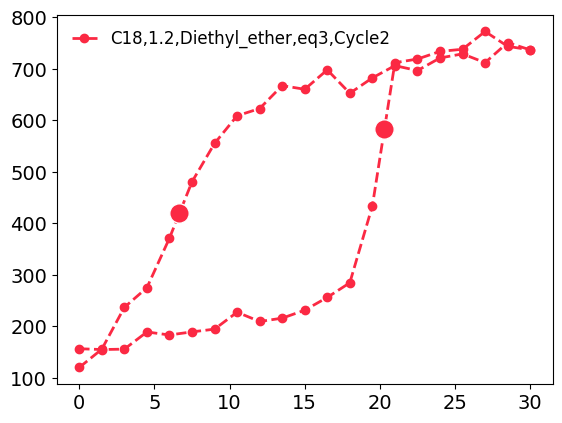

In [4]:
#save pints/pexts

def plot_cycle(ax,file_ie,color,line,label,cut,run=None):
   
    df = pd.read_csv(f"{file_ie}").sort_values(by="press")
    if run:
        df = df[df["run"] == run]
    if cut:
        df = df[df["press"] >= cut[0]]
        df = df[df["press"] <= cut[1]]

    x = np.linspace(df["press"].min(), df["press"].max(), 100)
    y = make_interp_spline(df["press"], df["mean"], k=1,bc_type=None)    
    dx = x[1] - x[0]
    dydx = FinDiff(0, dx, 1)
    dy = dydx(y(x))
    
    ymax = np.max(dy)
    xmax = x[dy == ymax]
    if len(xmax) > 1:
        xmax = np.mean(xmax)
    else:
        xmax = xmax[0]

    yp = np.max(y(xmax))

    ax.plot(df["press"],df["mean"], marker='o', lw=2, ls=line, color=color, label=label)    
    ax.plot(xmax, yp, ls="none", marker="o", markersize=14, mec="white", c=color, mfc=color)
    return df, xmax

from scipy.interpolate import make_interp_spline

colors = {"C8,0.6":"xkcd:light blue green","C8,1.0":"xkcd:turquoise","C8,1.2":"xkcd:dark blue green",
          "C12,0.6":"xkcd:baby blue","C12,1.0":"xkcd:mid blue","C12,1.2":"xkcd:navy","C18,0.6":"xkcd:soft pink",
          "C18,0.8":"xkcd:strawberry","C18,1.0":"xkcd:raspberry","C18,1.2":"xkcd:strawberry","C18,1.5":"xkcd:plum"}


systems = ["C8,1.2","C18,1.2"]
mol = "Diethyl_ether"
cycles = ["Cycle1","Cycle2"]  #use N1 for cycles without gas
runs = ["eq","eq2","eq3"]
cuts = {"C8,1.2":{"intrusion":[-13.5,16.5],"extrusion":[-13.5,16.5]},
        "C18,1.2":{"intrusion":[0,35], "extrusion":[0,35]}}
ngas = 1000

dfs_int = {}
dfs_ext = {}
pints = {}
pexts = {}

for sys,line in zip(systems,["solid","dashed"]):

    c, g = sys.split(',')[0], sys.split(',')[1]
    dfs_int[sys] = pd.DataFrame()
    dfs_ext[sys] = pd.DataFrame()
    pints[sys] = pd.DataFrame()
    pexts[sys] = pd.DataFrame()

    for cycle in cycles:

        for run in runs:

            fig, ax = plt.subplots(1,1)

            file_int = f"{root}/Int_ext_cycles/intrusion_{mol}_{c}_{g}_{ngas}_{run}_{cycle}.dat"
            file_ext = f"{root}/Int_ext_cycles/extrusion_{mol}_{c}_{g}_{ngas}_{run}_{cycle}.dat"
            
            df_int,pint = plot_cycle(ax,file_int,colors[sys],line,"",cuts[sys]["intrusion"],run)
            df_ext,pext = plot_cycle(ax,file_ext,colors[sys],line,f"{sys},{mol},{run},{cycle}",cuts[sys]["extrusion"],run)

            
            dfs_int[sys] = pd.concat([dfs_int[sys], df_int])
            dfs_ext[sys] = pd.concat([dfs_ext[sys], df_ext])

            pints[sys] = pd.concat([pints[sys], pd.DataFrame({"press":[pint],"run":[run]})])
            pexts[sys] = pd.concat([pexts[sys], pd.DataFrame({"press":[pext],"run":[run]})])
            
            ax.legend(frameon=False, handlelength=1.5, fontsize=12)  

        dfs_int[sys].to_csv(f"{root}/Int_ext_cycles/intrusion_{mol}_{c}_{g}_{ngas}_{cycle}.dat",index=False)
        dfs_ext[sys].to_csv(f"{root}/Int_ext_cycles/extrusion_{mol}_{c}_{g}_{ngas}_{cycle}.dat",index=False)

        pints[sys].to_csv(f"{root}/Int_ext_cycles/pints_{mol}_{c}_{g}_{ngas}_{cycle}.dat",index=False)
        pexts[sys].to_csv(f"{root}/Int_ext_cycles/pexts_{mol}_{c}_{g}_{ngas}_{cycle}.dat",index=False)


In [ ]:
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep, BSpline

def plot_av_cycle(ax,files,color,label,norm=False,cut_down="no",cut_up="no"):
    df = pd.read_csv(f"{files[0]}").reset_index()

    if cut_up != "no" :
        df = df[df["press"] <= cut_up]
    if cut_down != "no":
        print(cut_down)
        print(df["press"])
        df = df[df["press"] >= cut_down]

    if norm:
        norm_file = files[0].replace("intrusion","extrusion")
        df_norm = pd.read_csv(f"{norm_file}").reset_index()
        df["mean"] = df["mean"]/df_norm["mean"].max()


    pies = pd.read_csv(f"{files[1]}").reset_index()
    pie_mean, pie_std = pies["press"].mean(), pies["press"].std()/np.sqrt(len(pies))

    df_mean = df[["press","mean"]].groupby("press").mean().reset_index()
    df_mean["std"] = df[["press","mean"]].groupby("press").std().reset_index()["mean"]/np.sqrt(len(df["run"].unique()))

    x = np.linspace(df_mean["press"].min(),df_mean["press"].max(),100)

    y = make_interp_spline(df_mean["press"],df_mean["mean"],k=1,bc_type=None)   
    ydown = make_interp_spline(df_mean["press"],df_mean["mean"]-df_mean["std"],k=1,bc_type=None)
    yup =  make_interp_spline(df_mean["press"],df_mean["mean"]+df_mean["std"],k=1,bc_type=None) 
    ax.fill_betweenx(x,ydown(x),yup(x), alpha=0.3, color=color, ec="none", fc=color)

    ax.plot(df_mean["mean"],df_mean["press"], lw=1, ls="dashed", color=color, alpha=0.3)    
    ax.errorbar(y(pie_mean), pie_mean, yerr=pie_std, ls="none", marker="o", markersize=7, mec="white", mew=1.5, c=color, mfc=color, label=label)
    return df_mean

#colors = {"Chloroform,C8,1.2":"xkcd:pale magenta","Chloroform,C18,1.2":"xkcd:magenta",
#          "Ethylene,C8,1.2":"xkcd:pale teal","Ethylene,C18,1.2":"xkcd:teal",
#          "None,C8,1.2":"xkcd:pale orange","None,C18,1.2":"xkcd:pumpkin orange"}

colors = {"Chloroform,C8,1.2":"xkcd:magenta","Chloroform,C18,1.2":"xkcd:magenta",
          "Ethylene,C8,1.2":"xkcd:teal","Ethylene,C18,1.2":"xkcd:teal",
          "None,C8,1.2":"xkcd:pumpkin orange","None,C18,1.2":"xkcd:pumpkin orange"}

fig, axes = plt.subplots(2,1,figsize=(6,9),sharex=True)

systems = ["C8,1.2","C18,1.2"]
mols = ["Chloroform","Ethylene","None"]
cycles = ["Cycle2","Cycle2","N1"]

dfs_int = {}
dfs_ext = {}

for mol,cycle in zip(mols,cycles):
    for sys,cutDown,cutUp,ax in zip(systems,[-13.5,0],[15.0,30.0],axes):
        c, g = sys.split(',')[0], sys.split(',')[1]
        dfs = {}
        try:
            for ie,pie,label in zip(["intrusion","extrusion"],["pints","pexts"],["",f"{sys},{mol}"]):

                file_ie = f"{root}/Int_ext_cycles/{ie}_{mol}_{c}_{g}_{cycle}.dat"
                file_pie = f"{root}/Int_ext_cycles/{pie}_{mol}_{c}_{g}_{cycle}.dat"

                df = plot_av_cycle(ax,[file_ie,file_pie],colors[mol+","+sys],label,norm=True,cut_down=cutDown, cut_up=cutUp)
                dfs[ie] = df
        except Exception as err:
            print(err)
            continue

        dfs["intrusion"].to_csv(f"{root}/Int_ext_cycles/mean_intrusion_{mol}_{sys}_{cycle}.dat",index=False)
        dfs["extrusion"].to_csv(f"{root}/Int_ext_cycles/mean_extrusion_{mol}_{sys}_{cycle}.dat",index=False)
        ax.tick_params(which='major', length=6, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)

axes[0].legend(frameon=True, handlelength=2.5, fontsize=12, framealpha=0.7, facecolor="white", edgecolor="xkcd:light gray", loc="lower right")  
axes[1].legend(frameon=True, handlelength=2.5, fontsize=12, framealpha=0.7, facecolor="white", edgecolor="xkcd:light gray", loc="lower right")  

axes[0].set_ylabel("Pressure (MPa)",size=14)
axes[1].set_ylabel("Pressure (MPa)",size=14)
axes[1].set_xlabel("Fill. fraction",size=14)

fig.subplots_adjust(hspace=0)